In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
from typing import Any, Optional

import evals.core.main as core
import evals.scr_and_tpp.main as scr_and_tpp
import evals.sparse_probing.main as sparse_probing
import sae_bench_utils.general_utils as general_utils
import custom_saes.custom_sae_config as custom_sae_config
import custom_saes.vanilla_sae as vanilla_sae
from sae_bench_utils.sae_selection_utils import get_saes_from_regex
import custom_saes.run_all_evals_custom_saes as run_all_evals_custom_saes

RANDOM_SEED = 42

output_folders = {
    "absorption": "eval_results/absorption",
    "autointerp": "eval_results/autointerp",
    "core": "eval_results/core",
    "scr": "eval_results/scr",
    "tpp": "eval_results/tpp",
    "sparse_probing": "eval_results/sparse_probing",
    "unlearning": "eval_results/unlearning",
}

# Note: Unlearning is not recommended for models with < 2B parameters and we recommend an instruct tuned model
# Unlearning will also require requesting permission for the WMDP dataset (see unlearning/README.md)
# Absorption not recommended for models < 2B parameters
# asyncio doesn't like notebooks, so autointerp must be ran using a python script

# Select your eval types here. 
eval_types = [
    "absorption",
    # "autointerp",
    "core",
    "scr",
    "tpp",
    "sparse_probing",
    # "unlearning",
]

if "autointerp" in eval_types:
    raise ValueError("autointerp must be ran using a python script")

device = general_utils.setup_environment()

model_name = "gemma-2-2b"
llm_batch_size = 32
dtype = "bfloat16"


# If evaluating multiple SAEs on the same layer, set save_activations to True
# This will require at least 100GB of disk space
save_activations = False

Using device: cuda


This cell loads your custom SAEs. If you just want to use existing SAE Lens SAEs, comment it out.

In [ ]:


repo_id = "canrager/lm_sae"
baseline_filename = "pythia70m_sweep_standard_ctx128_0712/resid_post_layer_4/trainer_8/ae.pt"
hook_layer = 4
hook_name = f"blocks.{hook_layer}.hook_resid_post"

sae = vanilla_sae.load_vanilla_sae(repo_id, baseline_filename, hook_layer)
sae = sae.to(device, dtype=general_utils.str_to_dtype(dtype))

print(f"sae dtype: {sae.dtype}, device: {sae.device}")

d_sae, d_in = sae.W_dec.data.shape

assert d_sae >= d_in

print(f"d_in: {d_in}, d_sae: {d_sae}")

In our sae object we need to have a CustomSAEConfig. This contains some information which is used by the evals (hook_name, hook_layer, model_name, d_sae, etc). In addition, it contains information that is used by our plotting functions, like number of training tokens and architecture. For example, we should have the sae.cfg.architecture defined if we want to plot multiple SAE architectures.

In [45]:
sae.cfg = custom_sae_config.CustomSAEConfig(
    model_name, d_in=d_in, d_sae=d_sae, hook_name=hook_name, hook_layer=hook_layer
)

# Core evals require us to specify the dtype. This must be a string that can be converted to a torch dtype using general_utils.str_to_dtype.
sae.cfg.dtype = dtype


# The following contains our current defined SAE types and the shapes to plot for each. Add your custom SAE as new_sae_key
new_sae_key = "vanilla"
trainer_markers = {
    "standard": "o",
    "jumprelu": "X",
    "topk": "^",
    "p_anneal": "*",
    "gated": "d",
    new_sae_key: "s",  # New SAE
}

sae.cfg.architecture = new_sae_key
sae.cfg.training_tokens = 200_000_000

NameError: name 'd_in' is not defined

`selected_saes` is a list of tuples of (unique_sae_id, sae object) OR (sae lens release, sae lens id). If it is a list of custom sae objects, then memory size will increase with the length of the list. This is especially important if the SAEs are large. If memory is a concern, I recommend calling the `run_eval()` function multiple times with lists of length 1, each list containing a new sae object.

In [ ]:
# Note: the custom_sae_id should be unique, as it is used for the intermediate results and final results file names

unique_custom_sae_id = baseline_filename.replace("/", "_").replace(".", "_")
print(f"sae_id: {unique_custom_sae_id}")

# list of tuple of (sae_id, sae object)
custom_saes = [(unique_custom_sae_id, sae)]

Select your baseline SAEs here. Refer to `sae_regex_selection.ipynb` for more regex patterns. We are going to get a topk SAE from the same layer.

In [36]:
# sae_regex_pattern = r"(sae_bench_pythia70m_sweep_topk_ctx128_0730).*"
# sae_block_pattern = r".*blocks\.([4])\.hook_resid_post__trainer_(8)$"
# sae_regex_pattern = r"gemma-2-2b_layer_5_additivity.*"
# sae_block_pattern = r".*_trainer_0"

baseline_saes = get_saes_from_regex(sae_regex_pattern, sae_block_pattern)
print(f"baseline_saes: {baseline_saes}")
baseline_sae_id = f"{baseline_saes[0][0]}_{baseline_saes[0][1]}".replace(".", "_")
print(f"baseline_sae_id: {baseline_sae_id}")

baseline_saes

100%|██████████| 57/57 [00:00<00:00, 90387.65it/s]

baseline_saes: []


IndexError: list index out of range

Run time for the next 2 functions is approximately 2 minutes on an RTX 3090.

In [ ]:
# Note: We typically run with n_eval_sparsity_variance_batches=2000, but I have reduced it here for a faster run

_ = core.multiple_evals(
    selected_saes=selected_saes,
    n_eval_reconstruction_batches=200,
    n_eval_sparsity_variance_batches=200,
    eval_batch_size_prompts=32,
    compute_featurewise_density_statistics=False,
    compute_featurewise_weight_based_metrics=False,
    exclude_special_tokens_from_reconstruction=True,
    dataset="Skylion007/openwebtext",
    context_size=128,
    output_folder="eval_results/core",
    verbose=True,
    dtype=dtype,
)

In [ ]:
# We do a subset of the sparse probing datasets here for shorter runtime
dataset_names = ["LabHC/bias_in_bios_class_set1"]

# TODO: Add a verbose flag

_ = sparse_probing.run_eval(
    sparse_probing.SparseProbingEvalConfig(
        model_name=model_name,
        random_seed=RANDOM_SEED,
        llm_batch_size=llm_batch_size,
        llm_dtype=dtype,
        dataset_names=dataset_names,
    ),
    selected_saes,
    device,
    "eval_results/sparse_probing",
    force_rerun=False,
    clean_up_activations=True,
    save_activations=save_activations,
)


The below cell will run all evals on the full datasets. By default, we don't do this as it's pretty time consuming (~1 hour).

In [ ]:
# _ = run_all_evals_custom_saes.run_evals(
#     model_name,
#     selected_saes,
#     llm_batch_size,
#     dtype,
#     device,
#     eval_types,
#     api_key,
#     force_rerun=False,
#     save_activations=save_activations,
# )

In [3]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

import sae_bench_utils.graphing_utils as graphing_utils

from sae_bench_utils.sae_selection_utils import select_saes_multiple_patterns

In [4]:
eval_path = "./eval_results/absorption"

core_results_path = "./eval_results/core"
image_path = "./images"

if not os.path.exists(image_path):
    os.makedirs(image_path)

In [23]:
from custom_saes.topk_sae import load_topk_sae

repo_id = "webcrg/additivity"
hook_layer = 5

selected_saes = []
for trainer_id in range(4):
    trainer_path = f"gemma-2-2b_layer-4_width-2pow13_date-1204/trainer_{trainer_id}"
    filename = os.path.join(trainer_path, "ae.pt")
    config_filename = os.path.join(trainer_path, "config.json")
    sae = load_topk_sae(repo_id, filename, config_filename, hook_layer)
    # sae = identity_sae.IdentitySAE(model_name, d_model, hook_layer, context_size=128)
    selected_saes.append((f"{model_name}_layer_{hook_layer}_additivity_trainer_{trainer_id}", sae))

/share/u/can/SAEBench/custom_saes/topk_sae.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_params = t.load(path_to_params)


Loaded config: {'trainer': {'trainer_class': 'TrainerTopKAdditivity', 'dict_class': 'AutoEncoderTopK', 'lr': 0.000282842712474619, 'steps': 48828, 'seed': 0, 'activation_dim': 2304, 'dict_size': 8192, 'k': 20, 'auxk_alpha': 0.03125, 'additivity_coeff': 0.0, 'intersection_coeff': 0.0, 'device': 'cuda:0', 'layer': 4, 'lm_name': 'google/gemma-2-2b', 'wandb_name': 'TopKTrainer_Additivity-google/gemma-2-2b-resid_post_layer_4-add_coeff-0.0-inters_coeff-0.0', 'submodule_name': 'resid_post_layer_4'}, 'buffer': {'d_submodule': 2304, 'io': 'out', 'n_ctxs': 8192, 'ctx_len': 128, 'refresh_batch_size': 32, 'out_batch_size': 2048, 'device': 'cuda:0'}}
Original keys in state_dict: odict_keys(['b_dec', 'encoder.weight', 'encoder.bias', 'decoder.weight'])
Renamed keys in state_dict: dict_keys(['b_dec', 'W_enc', 'b_enc', 'W_dec'])
Loaded config: {'trainer': {'trainer_class': 'TrainerTopKAdditivity', 'dict_class': 'AutoEncoderTopK', 'lr': 0.000282842712474619, 'steps': 48828, 'seed': 0, 'activation_dim':

In [38]:
custom_sae_ids = []

for sae_id, sae in selected_saes:
    custom_sae_ids.append((sae_id, "custom_sae"))

# sae_lens_ids = []

# for sae_id, sae_release in baseline_saes:
#     sae_lens_ids.append((sae_id, sae_release))

graphing_sae_ids = custom_sae_ids # + sae_lens_ids

Here we can view the raw results, and we see that both SAEs significantly outperform the residual stream baseline.

In [39]:
graphing_sae_ids

[('gemma-2-2b_layer_5_additivity_trainer_0', 'custom_sae'),
 ('gemma-2-2b_layer_5_additivity_trainer_1', 'custom_sae'),
 ('gemma-2-2b_layer_5_additivity_trainer_2', 'custom_sae'),
 ('gemma-2-2b_layer_5_additivity_trainer_3', 'custom_sae')]

In [40]:
raw_results_dict = graphing_utils.get_results_dict(graphing_sae_ids, eval_path, core_results_path)

print(raw_results_dict.keys())

dict_keys(['gemma-2-2b_layer_5_additivity_trainer_0_custom_sae', 'gemma-2-2b_layer_5_additivity_trainer_1_custom_sae', 'gemma-2-2b_layer_5_additivity_trainer_2_custom_sae', 'gemma-2-2b_layer_5_additivity_trainer_3_custom_sae'])


In [42]:
custom_sae_id = f"{custom_sae_ids[0][0]}_{custom_sae_ids[0][1]}".replace(".", "_")
# baseline_sae_id = f"{sae_lens_ids[0][0]}_{sae_lens_ids[0][1]}"


# baseline_filename = f"{sae_lens_ids[0][0]}_{sae_lens_ids[0][1]}_eval_results.json".replace("/", "_")
# baseline_filepath = os.path.join(eval_path, baseline_filename)

# with open(baseline_filepath, "r") as f:
#     baseline_sae_eval_results = json.load(f)

custom_filename = f"{custom_sae_ids[0][0]}_{custom_sae_ids[0][1]}_eval_results.json".replace("/", "_")
custom_filepath = os.path.join(eval_path, custom_filename)

with open(custom_filepath, "r") as f:
    custom_sae_eval_results = json.load(f)

# k = 1

# print(baseline_sae_eval_results.keys())

# print(f"Baseline SAE top {k} accuracy was:", baseline_sae_eval_results["eval_result_metrics"]['sae'][f'sae_top_{k}_test_accuracy'])
# print(f"Custom SAE top {k} accuracy was:", custom_sae_eval_results["eval_result_metrics"]['sae'][f'sae_top_{k}_test_accuracy'])
# print(f"LLM top {k} accuracy was:" , baseline_sae_eval_results["eval_result_metrics"]['llm'][f'llm_top_{k}_test_accuracy'])

We can also plot the metrics, plotting L0 vs Custom Metric or L0 vs Loss Recovered vs Custom metric. We can have different shapes for the SAE type or dictionary size.

In [43]:
k=1

In [46]:
trainer_markers = {
    "standard": "o",
    "jumprelu": "X",
    "topk": "^",
    "p_anneal": "*",
    "gated": "d",
    # new_sae_key: "s",  # New SAE
}

In [50]:
image_base_name

'./images/absorption'

{'gemma-2-2b_layer_5_additivity_trainer_0_custom_sae': {'mean_absorption_score': 0.1354606266610463, 'mean_num_split_features': 2.0, 'eval_config': {'model_name': 'gemma-2-2b', 'random_seed': 42, 'f1_jump_threshold': 0.03, 'max_k_value': 10, 'prompt_template': '{word} has the first letter:', 'prompt_token_pos': -6, 'llm_batch_size': 32, 'llm_dtype': 'bfloat16', 'k_sparse_probe_l1_decay': 0.01, 'k_sparse_probe_batch_size': 4096, 'k_sparse_probe_num_epochs': 50}, 'sae_class': '', 'd_sae': 8000, 'train_tokens': 1e-06, 'l0': 19.999998092651367, 'frac_recovered': 0.8585526315789473}, 'gemma-2-2b_layer_5_additivity_trainer_1_custom_sae': {'mean_absorption_score': 0.14887349997275068, 'mean_num_split_features': 2.0, 'eval_config': {'model_name': 'gemma-2-2b', 'random_seed': 42, 'f1_jump_threshold': 0.03, 'max_k_value': 10, 'prompt_template': '{word} has the first letter:', 'prompt_token_pos': -6, 'llm_batch_size': 32, 'llm_dtype': 'bfloat16', 'k_sparse_probe_l1_decay': 0.01, 'k_sparse_probe_b

UnboundLocalError: cannot access local variable 'scatter' where it is not associated with a value

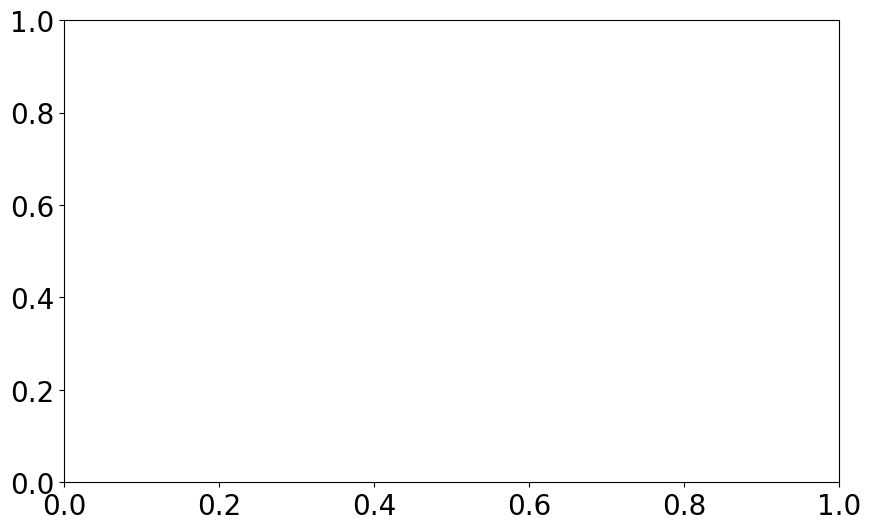

In [53]:
image_base_name = os.path.join(image_path, "absorption")

graphing_utils.plot_results(graphing_sae_ids, eval_path, core_results_path, image_base_name, k, trainer_markers)